# <span style="color:blue">Batch Normalization ([Szegedy, Ioffe 2015](https://arxiv.org/pdf/1502.03167.pdf))</span>
### Additional Resources:

[Ian Goodfellow: Deep Learning chapter 8.7.1](http://www.deeplearningbook.org/contents/optimization.html) for a more in-depth explanation

or more picturesque for your 4-year old daughter: [Lab41 in Medium](https://gab41.lab41.org/batch-normalization-what-the-hey-d480039a9e3b)

#### Normalization in a dense layer 
Normalize before activation: Consider a batch B of size m: Output $z = W \cdot x$

Mini-batch mean over z (element-wise): $\mu_B := \frac{1}{m}\sum_{i=1}^{m}z_i$

Variance: $\sigma_B^2 := \frac{1}{m}\sum_{i=1}^m(\mu_B - z_i)^2$

Normalize: $\hat{z}_i := \frac{z_i - \mu_b}{\sqrt{\sigma_B^2 + \epsilon}}$

Scale and shift: $ BN_{\gamma,\beta}(\hat{z}_i) := \gamma \cdot \hat{z}_i + \beta$ 

Only then apply activation function

In [1]:
from mnist import train_batcher as batcher
from mnist import test_batcher as tbatcher

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import json

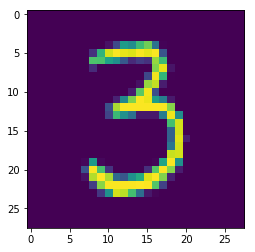

In [3]:
imgs_, _ = batcher.next_batch(100)
if not batcher.has_more():
    batcher.reset()
else:
    plt.imshow(imgs_[50, :, :])
    plt.show()

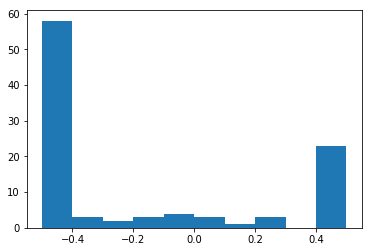

In [4]:
x1010 = np.squeeze(imgs_[:, 10, 10])
plt.hist(x1010)
plt.show()

In [5]:
def normalize_batch(x, gamma, beta):
    epsilon = 1e-8
    m = x.shape[0]
    mu_b=np.sum(x, axis=0)/m
    s2 = np.sum((x - mu_b)**2, axis=0)/m
    x_hat = (x - mu_b)/np.sqrt(s2 + epsilon)
    return beta + gamma*x_hat

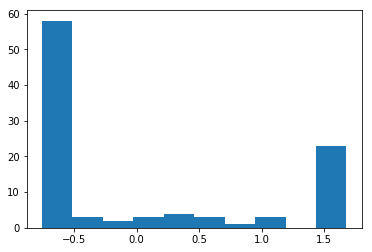

In [6]:
normalized = normalize_batch(imgs_, gamma=1, beta=0)
n1010 = np.squeeze(normalized[:, 10, 10])
plt.hist(n1010)
plt.show()

The normalized amplitudes have average 0 and stdev = 1

In [7]:
x=normalized[:, 10, 10]
m=x.shape[0]
avg=np.sum(x, axis=0)/m
stdev = np.sqrt(np.sum((x - avg)**2, axis=0)/m)
avg, stdev

(1.1920928955078126e-08, 0.99999977111813787)

## Translational degrees of freedom
$\beta$ and $\gamma$ now are also learnable parameters. The network hopefully chooses to use this degree of freedom wisely such that it benefits most from the non-linearity. 

Note that e.g. the popular sigmoid function 
$$ \sigma(x) = \frac{1}{1+e^{-x}}$$
gets more linear, when x is close to 0. The more linear the activation is, the less expressive the network becomes, as any two dense layers $(M \times N), (N \times P)$, are equivalent to a single dense layer $(M \times P)$, if not separated by a non-linearity. 

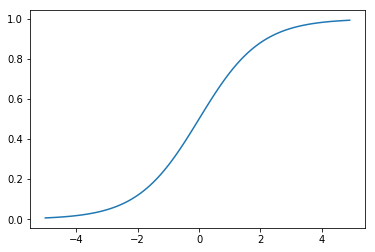

In [8]:
a_x=np.array([x/10.0-5 for x in range(100)])
sigmoid=1/(1.0+np.exp(-a_x))
plt.plot(a_x,sigmoid)
plt.show()


# <span style="color:blue">Tensorflow</span>

In [9]:
import tensorflow as tf
tf.reset_default_graph()
sess=tf.InteractiveSession()

### Placeholders: Input and Labels

In [10]:
X=tf.placeholder(shape=[None, 784], dtype=tf.float32, name="X")

LBLS=tf.cast(tf.placeholder(shape=[None], dtype=tf.float32, name="Y_"), dtype=tf.int64)

Y_=tf.one_hot(tf.cast(LBLS, dtype=tf.int32), 10)

X, LBLS, Y_

(<tf.Tensor 'X:0' shape=(?, 784) dtype=float32>,
 <tf.Tensor 'Cast:0' shape=(?,) dtype=int64>,
 <tf.Tensor 'one_hot:0' shape=(?, 10) dtype=float32>)

## Batch Norm Tensor 

In [11]:
beta = tf.get_variable(initializer=tf.constant(0.0), name="beta")
gamma = tf.get_variable(initializer=tf.constant(1.0), name="gamma")
def tf_normalize(x, gamma=tf.constant(1.0), beta=tf.constant(0.0)):
    epsilon = tf.constant(1e-8, name="epsilon")
    mu_b=tf.reduce_mean(x, axis=0)
    s2 = tf.reduce_mean(tf.square(x - mu_b), axis=0, name="s2")
    x_hat = tf.divide((x - mu_b),tf.sqrt(s2 + epsilon))
    return beta + gamma * x_hat

## Create a simple 3-layer dense net

In [12]:
def add_stats (stats, name, tensor):
    """
    Little helper to get useful statistics out of the model
    takes a stats dictionary and adds min/max/mean stats to it, using 'name' as the key
    """    
    mean = tf.reduce_mean(tensor)
    stats[name] = {
        "mean": tf.reduce_mean(tensor),
        "min": tf.reduce_min(tensor),
        "max": tf.reduce_max(tensor)        
    }
    return stats


def dense(name, input, dim_in, dim_out, stats):
    """
    dense layer, adding statistics about weights and biases
    """    
    with tf.name_scope(name):
        W = tf.Variable(initial_value=tf.random_normal(shape=[dim_out, dim_in], mean=0.0, stddev=1e-2), name="W")
        add_stats(stats, name+"_W", W)
        b = tf.Variable(initial_value=np.zeros([dim_out]), dtype=tf.float32, name="b")
        add_stats(stats, name+"_b", b)
    return tf.matmul(input, tf.transpose(W)) + tf.transpose(b)

In [13]:
def model_forward(X, use_bn=False, name_scope="default"):
    """
    A three dense-layer forward feed
    if use_bn == true, will use batch normalization after the first and second layer
    the input will be normalized, anyway
    X: the input vector of shape (batch_size, 784)
    """

    with tf.name_scope(name_scope):
        beta1 = tf.Variable(initial_value=tf.constant(0.0), name="beta1")
        gamma1 = tf.Variable(initial_value=tf.constant(1.0), name="gamma1")
        beta2 = tf.Variable(initial_value=tf.constant(0.0), name="beta2")
        gamma2 = tf.Variable(initial_value=tf.constant(1.0), name="gamma2")

        stats={}
        X_norm = tf_normalize(X) # This is input normalization - whitening.
        affine1 = dense(input=X_norm, name="Layer1", dim_in=784, dim_out=256, stats=stats)
        if use_bn:
            affine1=tf_normalize(affine1, beta=beta1, gamma=gamma1)
        act1 = tf.nn.relu(affine1)
        affine2 = dense(input=act1, name="Layer2", dim_in=256, dim_out=64, stats=stats)
        if use_bn:
            affine2=tf_normalize(affine2, beta=beta2, gamma=gamma2)
        act2 = tf.nn.relu(affine2)
        logits = dense(input=act2, name="Layer3", dim_in=64, dim_out=10, stats=stats)
        pred = tf.nn.softmax(logits, dim=1)
    return pred, logits, stats, beta1, gamma1, beta2, gamma2

## The network without batch normalization

In [14]:
pred, logits, stats, beta1, gamma1, beta2, gamma2 = model_forward(X, name_scope="without_BN", use_bn=False)
preds = tf.arg_max(pred, dimension=1)
acc = tf.reduce_mean(tf.cast(tf.equal(x=preds,y=LBLS), dtype=tf.float32))
loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=Y_, logits=logits))
pred, loss, preds, LBLS, Y_

(<tf.Tensor 'without_BN/Softmax:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'Sum:0' shape=() dtype=float32>,
 <tf.Tensor 'ArgMax:0' shape=(?,) dtype=int64>,
 <tf.Tensor 'Cast:0' shape=(?,) dtype=int64>,
 <tf.Tensor 'one_hot:0' shape=(?, 10) dtype=float32>)

## The network with batch normalization

In [15]:
pred1, logits1, stats1, beta1, gamma1, beta2, gamma2= model_forward(X, name_scope="with_BN", use_bn=True)
preds1 = tf.arg_max(pred1, dimension=1)
acc1 = tf.reduce_mean(tf.cast(tf.equal(x=preds1,y=LBLS), dtype=tf.float32))
loss1 = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=Y_, logits=logits1))
pred1, loss1, preds1, LBLS, Y_

(<tf.Tensor 'with_BN/Softmax:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'Sum_1:0' shape=() dtype=float32>,
 <tf.Tensor 'ArgMax_1:0' shape=(?,) dtype=int64>,
 <tf.Tensor 'Cast:0' shape=(?,) dtype=int64>,
 <tf.Tensor 'one_hot:0' shape=(?, 10) dtype=float32>)

In [16]:
def train ( acc, loss, stats ):
    trainer=tf.train.AdamOptimizer(learning_rate=1e-4)
    step=trainer.minimize(loss=loss)
    num_epochs=10
    batch_size=1000
    _loss=-1
    _acc=0
    sess.run(tf.global_variables_initializer())
    batcher.reset()
    rec_loss=[]
    rec_acc=[]
    rec_tacc=[]
    rec_beta1=[]
    rec_gamma1=[]
    rec_beta2=[]
    rec_gamma2=[]
    print("batch size: %s" % batch_size)
    i = 0

    for i in range (num_epochs):
        batcher.reset()
        while batcher.has_more():

            imgs, lbls = batcher.next_batch(batch_size)
            imgs = imgs.reshape(-1, 784)
            _, _acc, _loss, _stats, _beta1, _gamma1, _beta2, _gamma2 = \
                sess.run([step, acc, loss, stats, beta1, gamma1, beta2, gamma2], 
                         feed_dict={X: imgs, LBLS: lbls })

            #
            #  accuracy on the first 1000 samples of the test set
            #
            tbatcher.reset()
            timgs, tlbls = tbatcher.next_batch(1000)
            timgs = timgs.reshape(-1, 784)
            _tacc = sess.run([acc], feed_dict={X: timgs, LBLS: tlbls })

            # 
            #  record the main metrics
            #
            rec_acc.append(_acc)
            rec_loss.append(_loss)
            rec_tacc.append(_tacc)
            rec_beta1.append(_beta1)
            rec_gamma1.append(_gamma1)
            rec_beta2.append(_beta2)
            rec_gamma2.append(_gamma2)

        print("Epoch %s, Accuracy: %s, Loss: %s" % (i, _acc, _loss))    
        print("gamma1: %s, beta1: %s, gamma2: %s, beta2: %s" % (_gamma1, _beta1, _gamma2, _beta2))

    print(_stats)
    print("Done")    
    return {"loss": rec_loss, "training_accuracy": rec_acc, "test_accuracy": rec_tacc, 
            "bn": {"beta1": rec_beta1, "gamma1": rec_gamma1, "beta2": rec_beta2, "gamma2": rec_gamma2}}


In [17]:
res = train ( acc, loss, stats )

batch size: 1000
Epoch 0, Accuracy: 0.612, Loss: 2161.97
gamma1: 1.0, beta1: 0.0, gamma2: 1.0, beta2: 0.0
Epoch 1, Accuracy: 0.636, Loss: 1425.61
gamma1: 1.0, beta1: 0.0, gamma2: 1.0, beta2: 0.0
Epoch 2, Accuracy: 0.787, Loss: 833.357
gamma1: 1.0, beta1: 0.0, gamma2: 1.0, beta2: 0.0
Epoch 3, Accuracy: 0.893, Loss: 541.774
gamma1: 1.0, beta1: 0.0, gamma2: 1.0, beta2: 0.0
Epoch 4, Accuracy: 0.913, Loss: 385.178
gamma1: 1.0, beta1: 0.0, gamma2: 1.0, beta2: 0.0
Epoch 5, Accuracy: 0.926, Loss: 301.625
gamma1: 1.0, beta1: 0.0, gamma2: 1.0, beta2: 0.0
Epoch 6, Accuracy: 0.938, Loss: 254.785
gamma1: 1.0, beta1: 0.0, gamma2: 1.0, beta2: 0.0
Epoch 7, Accuracy: 0.946, Loss: 225.015
gamma1: 1.0, beta1: 0.0, gamma2: 1.0, beta2: 0.0
Epoch 8, Accuracy: 0.951, Loss: 204.077
gamma1: 1.0, beta1: 0.0, gamma2: 1.0, beta2: 0.0
Epoch 9, Accuracy: 0.954, Loss: 188.437
gamma1: 1.0, beta1: 0.0, gamma2: 1.0, beta2: 0.0
{'Layer1_W': {'mean': -0.0059331837, 'min': -0.093842536, 'max': 0.09245263}, 'Layer1_b': {'m

In [ ]:
rec_loss_n = [l/2500 for l in res["loss"]]
plt.plot(res["training_accuracy"])
plt.plot(res["test_accuracy"])
plt.plot(rec_loss_n)
plt.show()

### Now using batch normalization 

In [ ]:
res = train ( acc1, loss1, stats1 )

In [ ]:
rec_loss_n = [l/2500 for l in res["loss"]]
plt.plot(res["training_accuracy"])
plt.plot(res["test_accuracy"])
plt.plot(rec_loss_n)
plt.show()

In [ ]:
beta1 = plt.plot(res["bn"]["beta1"])
beta2 = plt.plot(res["bn"]["beta2"])
gamma1 = plt.plot(res["bn"]["gamma1"])
gamma2 = plt.plot(res["bn"]["gamma2"])
plt.show()